## 1. Data Preprocessing

#### Load dataset

In [1]:
import pandas as pd
from tqdm import tqdm

from transform import PreProcessing

vnxpress = pd.read_csv('data/vnxpress.csv', encoding='utf-8')
shopee = pd.read_csv('data/shopee.csv', encoding='utf-8')

vnxpress

,content,label
0,Tôi thấy nếu đã gửi thông báo mà sàn thương mạ...,0
1,Người VN mình tự đầu độc nhau trên các sàn và ...,2
2,"Có lợi nhuận thì họ kinh doanh thôi, cái quan ...",2
3,"Làm mà không được thì tự chịu, làm mà trôi chả...",2
4,Vấn đề đó không liên quan ở đây bạn ạ. Nếu đã ...,0
...,...,...
6969,"chụp CT thì bth thôi, 2 3 tháng chụp là bth, t...",2
6970,"Không sao đâu chú, liều y tế quy định nên suất...",1
6971,Lương cao lắm,0
6972,Quan trọng là sức khoẻ. Lương cao thì xứng đán...,0


#### Tiền xử lý text

In [2]:
vnxpress['content'] = vnxpress['content'].apply(lambda x: PreProcessing(x).norm())
vnxpress['content'] = vnxpress['content'].fillna('')

shopee['content'] = shopee['content'].apply(lambda x: PreProcessing(x).norm() if isinstance(x, str) else '')
shopee['content'] = shopee['content'].fillna('')

data = pd.concat([vnxpress, shopee], axis=0)

data

,content,label
0,tôi thấy nếu đã gửi thông_báo mà sàn thương_mạ...,0
1,người việt nam mình tự đầu_độc nhau trên các s...,2
2,có lợi_nhuận thì họ kinh_doanh thôi cái quan_t...,2
3,làm mà không được thì tự chịu làm mà trôi_chảy...,2
4,vấn_đề đó không liên_quan ở đây bạn ạ nếu đã b...,0
...,...,...
31455,không đáng tiền,2
31456,quần rất đẹp,1
31457,hàng đẹp đúng giá tiền,1
31458,chất vải khá ổn,1


#### Đưa về TF-IDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()
data_tfidf = tfidf_vectorizer.fit_transform(data['content'])

X_train, X_test, y_train, y_test = train_test_split(data_tfidf, data['label'], test_size=0.2, random_state=42)

print(f"TF-IDF matrix shape: {data_tfidf.shape}")
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

TF-IDF matrix shape: (38434, 13766)
Training set size: (30747, 13766)
Testing set size: (7687, 13766)


## 2. Random Forest

#### Grid Search test

In [ ]:
from sklearn.model_selection import GridSearchCV

def perform_grid_search(X, y, param_grid, cv_splits=5):
    rf = RandomForestClassifier(random_state=42)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X, y)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy']
}

best_model = perform_grid_search(X_train, y_train, param_grid)

#### Hàm plot_scores

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline

def plot_scores(title, xlabel, x_values, score_mean, score_std, ylabel='Accuracy'):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.errorbar(x_values, score_mean, yerr=score_std, fmt='o-', capsize=5)
    plt.xticks(x_values)
    plt.show()

#### Thay đổi n_estimators, criterion = gini

100%|██████████| 4/4 [13:32<00:00, 203.11s/it]


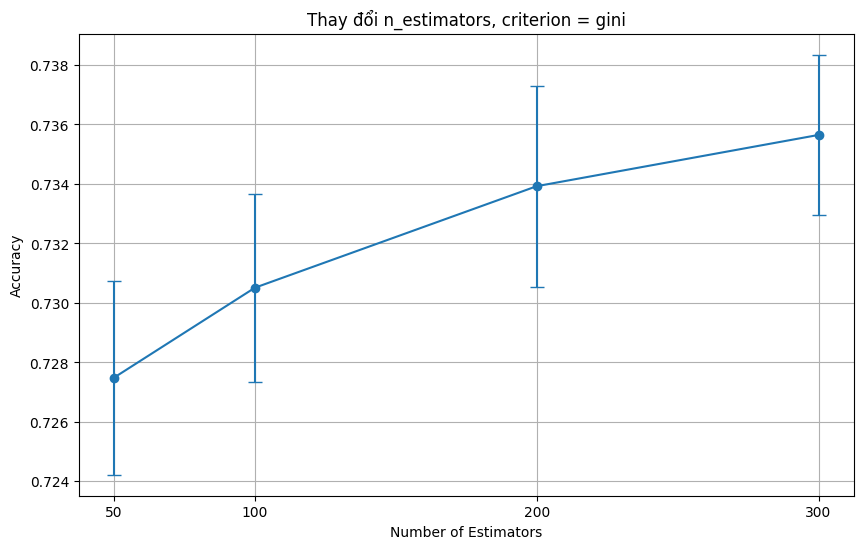

In [5]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

n_estimators = [50, 100, 200, 300]
criterion = 'gini'
score_mean = []
score_std = []

for n_est in tqdm(n_estimators):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = RandomForestClassifier(n_estimators=n_est, criterion=criterion, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi n_estimators, criterion = gini', 'Number of Estimators', n_estimators, score_mean, score_std)

#### Thay đổi criterion, n_estimators = 200

100%|██████████| 2/2 [08:27<00:00, 253.58s/it]


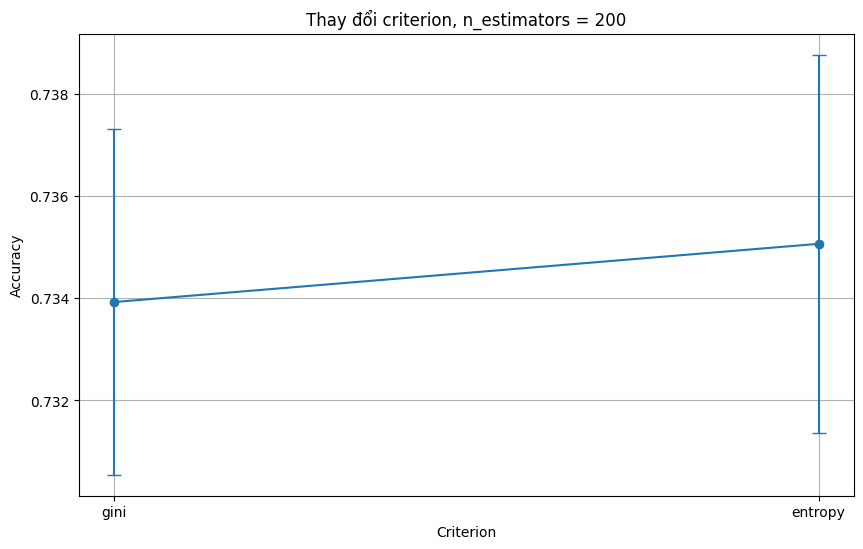

In [6]:
n_estimators = 200
criterion = ['gini', 'entropy']
score_mean = []
score_std = []

for crit in tqdm(criterion):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=crit, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi criterion, n_estimators = 200', 'Criterion', criterion, score_mean, score_std)

## 3. SVM

#### Grid search test

In [ ]:
from sklearn.svm import SVC

def perform_grid_search_svm(X, y, param_grid, cv_splits=5):
    svm = SVC(random_state=42)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X, y)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_

# Example usage
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

best_svm_model = perform_grid_search_svm(X_train, y_train, svm_param_grid)

#### Thay đổi kernel, C=1

100%|██████████| 4/4 [11:08<00:00, 167.11s/it]


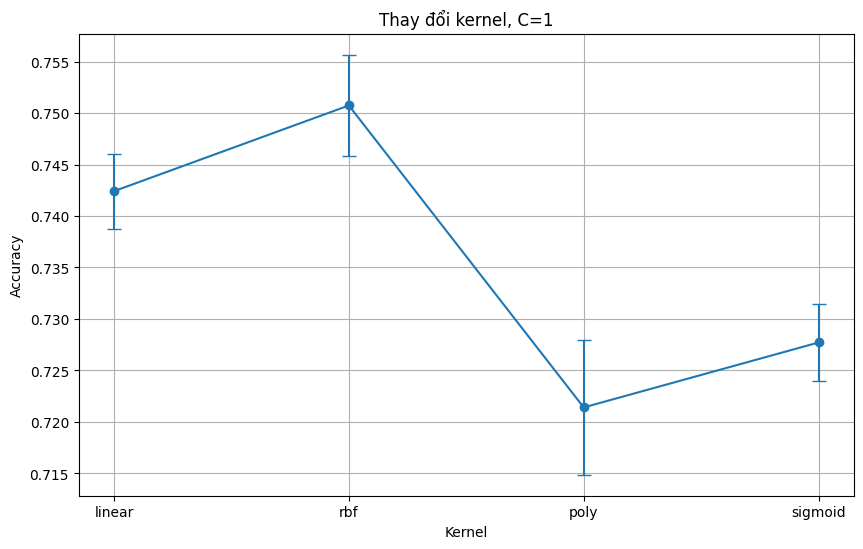

In [7]:
from sklearn.svm import SVC

kernel = ['linear', 'rbf', 'poly', 'sigmoid']
C = 1
score_mean = []
score_std = []

for k in tqdm(kernel):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = SVC(C=C, kernel=k, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi kernel, C=1', 'Kernel', kernel, score_mean, score_std)

#### Thay đổi C, kernel = rbf

100%|██████████| 6/6 [27:38<00:00, 276.36s/it]


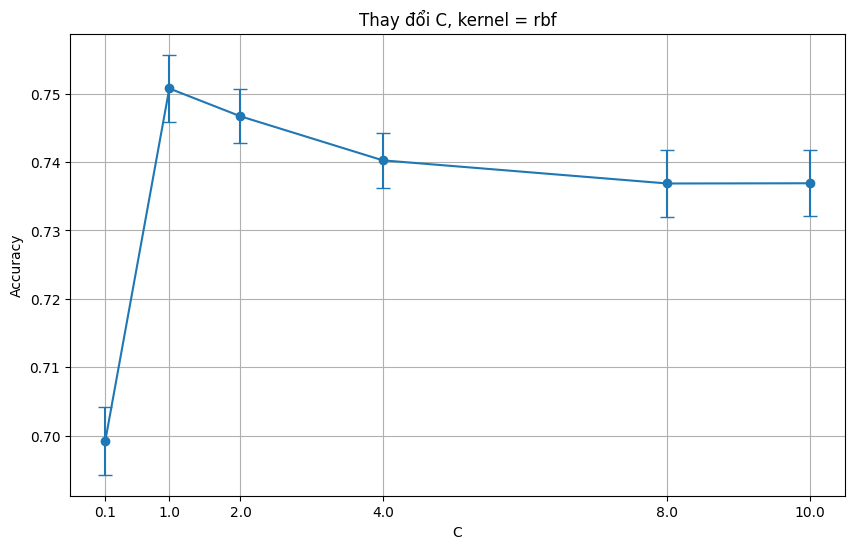

In [8]:
C = [0.1, 1, 2, 4, 8, 10]
kernel = 'rbf'
score_mean = []
score_std = []

for c in tqdm(C):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = SVC(C=c, kernel=kernel, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi C, kernel = rbf', 'C', C, score_mean, score_std)

## 4. So sánh 2 mô hình

In [9]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
svm = SVC(C=1, kernel='rbf')

In [10]:
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(C=1, random_state=42)

#### Classification report

In [13]:
from sklearn.metrics import classification_report

rf_predictions = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.16      0.24      1353
           1       0.82      0.89      0.85      4381
           2       0.63      0.79      0.70      1953

    accuracy                           0.74      7687
   macro avg       0.64      0.61      0.60      7687
weighted avg       0.71      0.74      0.71      7687



In [14]:
svm_predictions = svm.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.26      0.34      1353
           1       0.85      0.89      0.87      4381
           2       0.65      0.79      0.71      1953

    accuracy                           0.75      7687
   macro avg       0.66      0.65      0.64      7687
weighted avg       0.73      0.75      0.74      7687



#### Confusion matrix

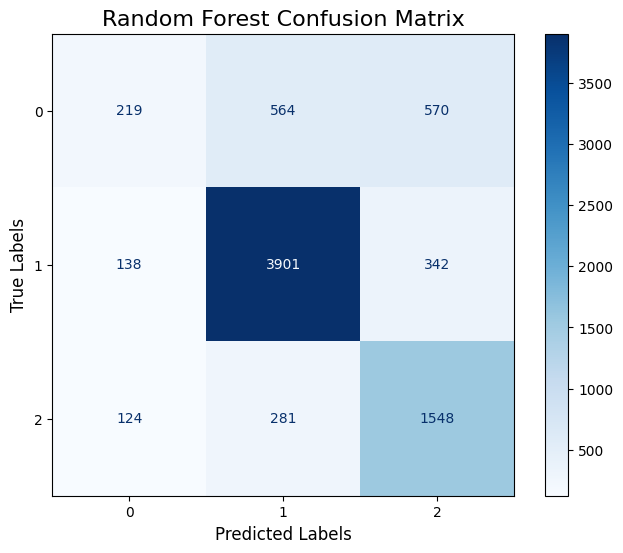

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Random Forest Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf.classes_)
fig_rf, ax_rf = plt.subplots(figsize=(8, 6))
disp_rf.plot(cmap='Blues', ax=ax_rf, colorbar=True)
plt.title("Random Forest Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()


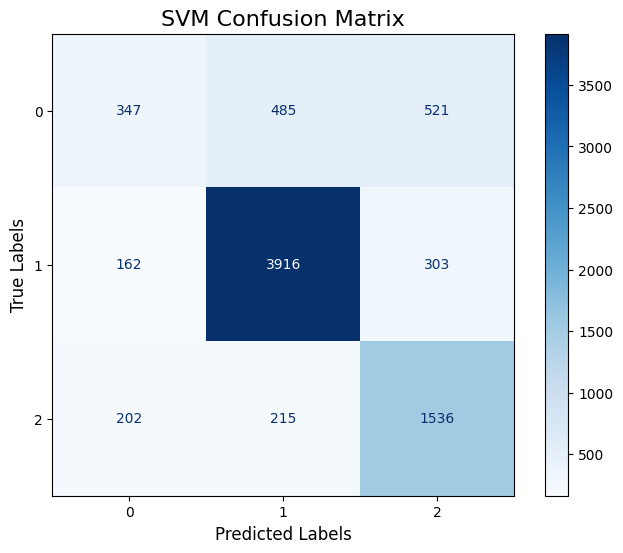

In [18]:
# SVM Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_predictions)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=svm.classes_)
fig_svm, ax_svm = plt.subplots(figsize=(8, 6))
disp_svm.plot(cmap='Blues', ax=ax_svm, colorbar=True)
plt.title("SVM Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()

## 5. RF-SVM